In [157]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from service.report_predict import predict_category, evaluate_model_with_kfold
from service.pipeline import (
    merge_dataframes, 
    dataframe_o3, 
    dataframe_gc, 
    PROCESSED_DATA_PATH, 
    parallel_process_texts, 
    ClassifierType, 
    get_model,
    logger
)

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

# Notebook Astromark AI

Questo notebook carica i dati dei ticket, li unisce e li preprocessa (utilizzando spaCy per tokenizzazione, lemmatizzazione e NER), costruisce la pipeline di ML, esegue la grid search, salva/carica il modello e infine fornisce un esempio di utilizzo del ticket service.

In [158]:
# Unione dei dataset
merged_df = merge_dataframes(dataframe_o3, dataframe_gc)
X = merged_df['titolo_messaggio']
y = merged_df['categoria']
logger.info("Final merged dataset shape: %s", merged_df.shape)

[INFO] Merging dataframes...
[INFO] Eliminate 291 righe duplicate
[INFO] Final merged dataset shape: (5237, 2)



Statistiche descrittive per categoria:
categoria
Segreteria    1088
Didattica     1085
Tecnico       1072
Accesso       1007
Profilo        985
dtype: int64

Percentuali per categoria:
categoria
Segreteria    20.78
Didattica     20.72
Tecnico       20.47
Accesso       19.23
Profilo       18.81
Name: proportion, dtype: float64


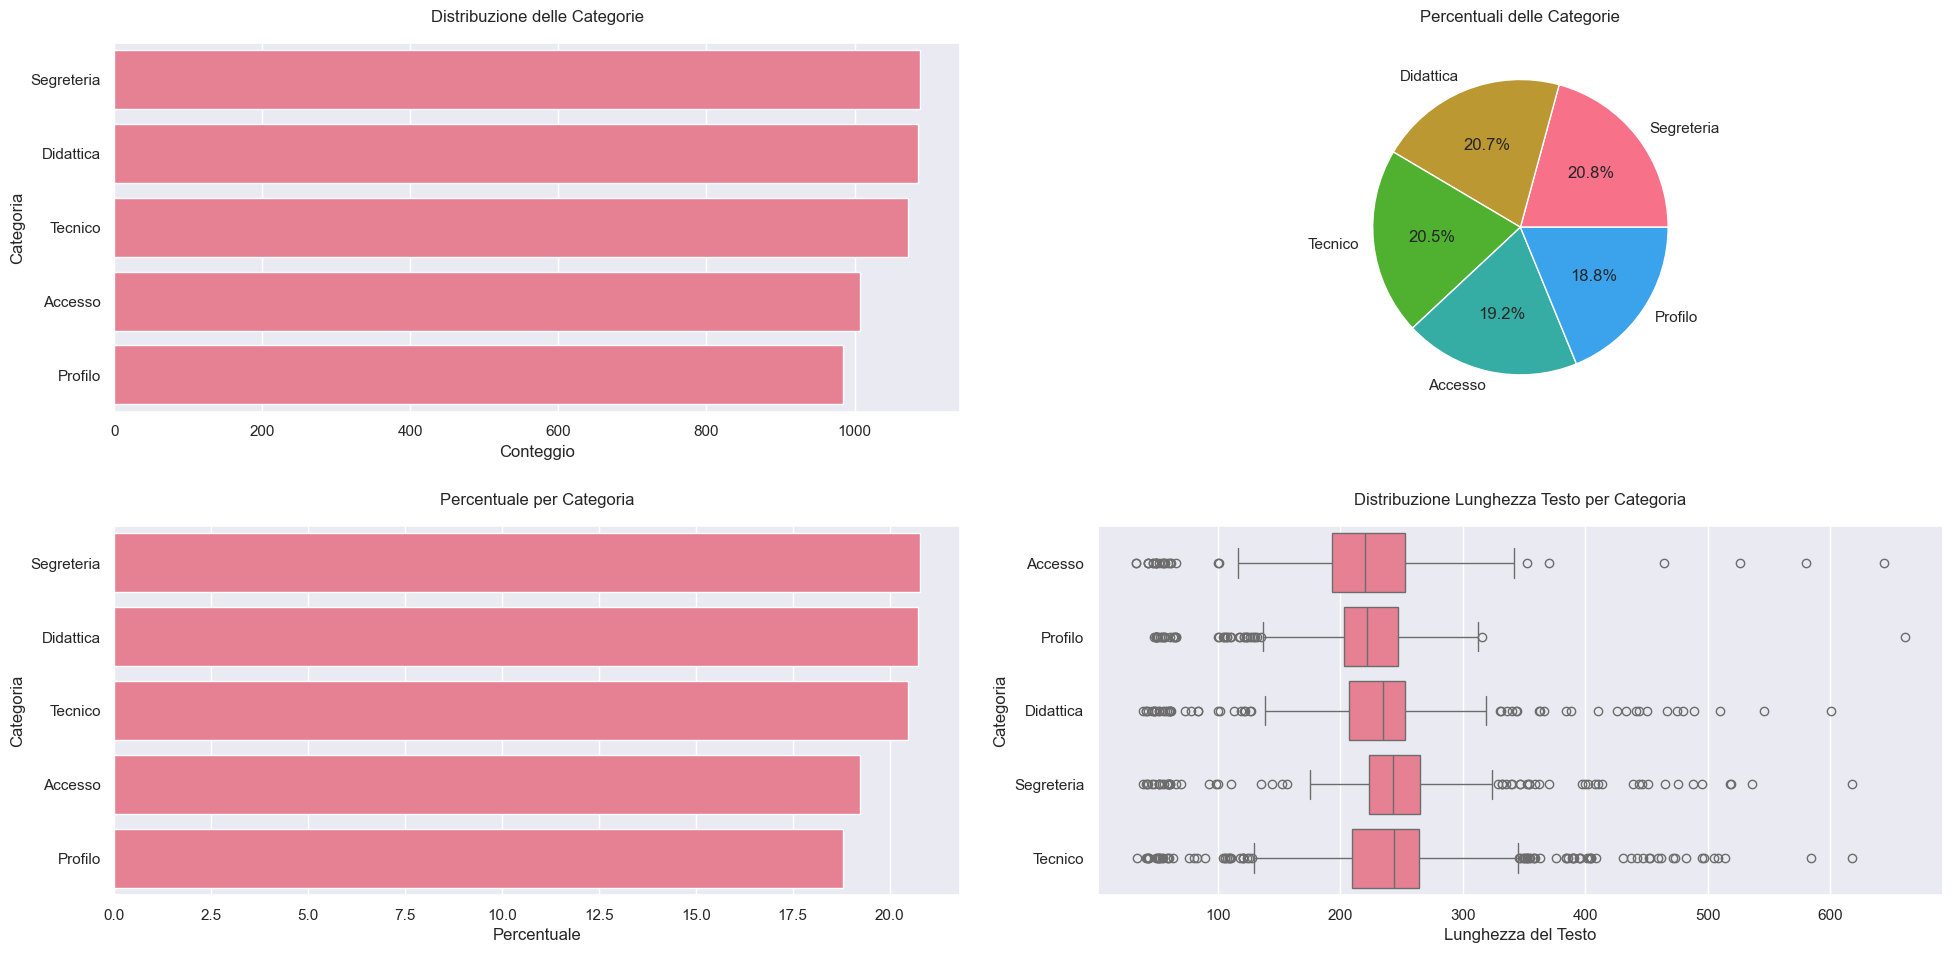

In [159]:
# Impostazioni per una migliore visualizzazione
plt.style.use('default')  # Utilizziamo lo stile default di matplotlib
sns.set_theme()  # Applica il tema base di seaborn
sns.set_palette("husl")

# Creazione di una figura con più sottografici
fig = plt.figure(figsize=(20, 10))

# 1. Grafico a barre della distribuzione delle categorie
plt.subplot(2, 2, 1)
sns.countplot(data=merged_df, y='categoria', order=merged_df['categoria'].value_counts().index)
plt.title('Distribuzione delle Categorie', pad=15)
plt.xlabel('Conteggio')
plt.ylabel('Categoria')

# 2. Grafico a torta delle percentuali
plt.subplot(2, 2, 2)
category_counts = merged_df['categoria'].value_counts()
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Percentuali delle Categorie', pad=15)

# 3. Grafico a barre orizzontale con percentuali
plt.subplot(2, 2, 3)
category_percentages = (merged_df['categoria'].value_counts(normalize=True) * 100)
sns.barplot(x=category_percentages.values, y=category_percentages.index)
plt.title('Percentuale per Categoria', pad=15)
plt.xlabel('Percentuale')
plt.ylabel('Categoria')

# 4. Box plot della lunghezza del testo per categoria
plt.subplot(2, 2, 4)
merged_df['text_length'] = merged_df['titolo_messaggio'].str.len()
sns.boxplot(data=merged_df, x='text_length', y='categoria')
plt.title('Distribuzione Lunghezza Testo per Categoria', pad=15)
plt.xlabel('Lunghezza del Testo')
plt.ylabel('Categoria')

# Aggiusta il layout
plt.tight_layout(pad=2.0)

# Mostra statistiche descrittive
print("\nStatistiche descrittive per categoria:")
print(merged_df.groupby('categoria').size().sort_values(ascending=False))
print("\nPercentuali per categoria:")
print(category_percentages.round(2))

# Mostra il plot
plt.show()

In [160]:
# Carica o processa i dati preprocessati
if os.path.exists(PROCESSED_DATA_PATH):
    logger.info("Loading preprocessed data from '%s'...", PROCESSED_DATA_PATH)
    df = pd.read_csv(PROCESSED_DATA_PATH)
    X_processed = df["processed_text"]
else:
    logger.info("Preprocessed data not found, starting parallel preprocessing...")
    X_processed = parallel_process_texts(X, n_jobs=-1)
    logger.info("Saving preprocessed data to: %s", PROCESSED_DATA_PATH)
    X_processed_df = pd.DataFrame(X_processed, columns=["processed_text"])
    X_processed_df.to_csv(PROCESSED_DATA_PATH, index=False)
    logger.info("Preprocessing complete and cached.")

[INFO] Preprocessed data not found, starting parallel preprocessing...
[INFO] Parallel text processing with threading backend...
[INFO] Saving preprocessed data to: C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\processed\X_processed.csv
[INFO] Preprocessing complete and cached.


## Fine della Pipeline

I dati sono stati caricati, preprocessati e il modello (ottenuto tramite Grid Search) è stato caricato o addestrato e salvato nella cartella `../data/trained`.

In [161]:
# Esempio: Funzione per il Ticket Service
def ticket_service(title, message, classifier_type):
    logger.info("Retrieving final model (Otherwise loading if already exists)...")
    model = get_model(classifier_type)
    
    logger.info(evaluate_model_with_kfold(model, X_processed, y, save_plots=False))
    
    full_text = f"{title} {message}".strip()
    if not full_text:
        return ["Nessun input fornito"]
    
    print("Calcolando la predizione per l'input: \"", full_text, "\"...")
    logger.info("Predict Category of: " + full_text + "...")
    predictions = predict_category(full_text, classifier_type)
    print("Predizioni:", predictions)
    return predictions

## Esempio di utilizzo con SVM

[INFO] Retrieving final model (Otherwise loading if already exists)...
[INFO] No saved model found for svm. Training a new one...
[INFO] Building pipeline for svm...
[INFO] Starting grid search for svm with parameters: {'tfidf__min_df': [1, 3], 'tfidf__max_df': [0.85, 0.9], 'svd__n_components': [30, 50], 'clf__C': [0.1, 0.5, 1.0]}


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[INFO] Grid search for svm complete.
[INFO] Best parameters: {'clf__C': 1.0, 'svd__n_components': 50, 'tfidf__max_df': 0.85, 'tfidf__min_df': 3}
[INFO] Model saved to C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_svm.pkl.
[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.8950
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.932845  0.949068  0.940887   805.000000
Didattica      0.850649  0.905530  0.877232   868.000000
Profilo        0.953905  0.945431  0.949649   788.000000
Segreteria     0.915493  0.820896  0.865617   871.000000
Tecnico        0.835973  0.862310  0.848937   857.000000
accuracy       0.894963  0.894963  0.894963     0.894963
macro avg      0.897773  0.896647  0.896465  4189.000000
weighted avg   0.896349  0.894963  0.894884  4189.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo

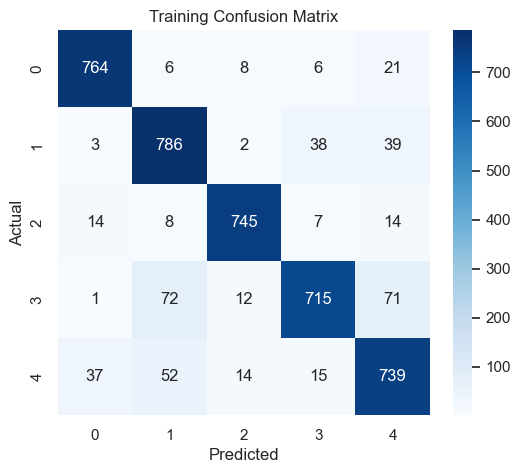

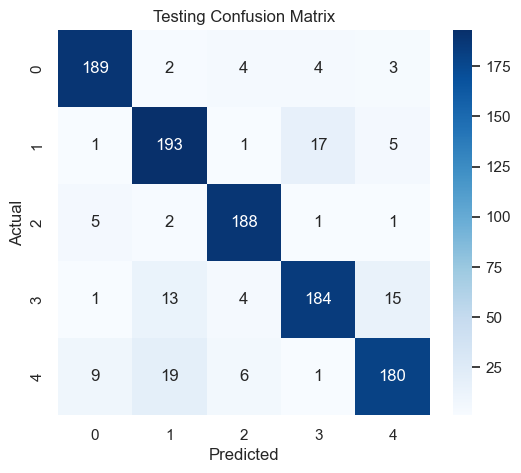

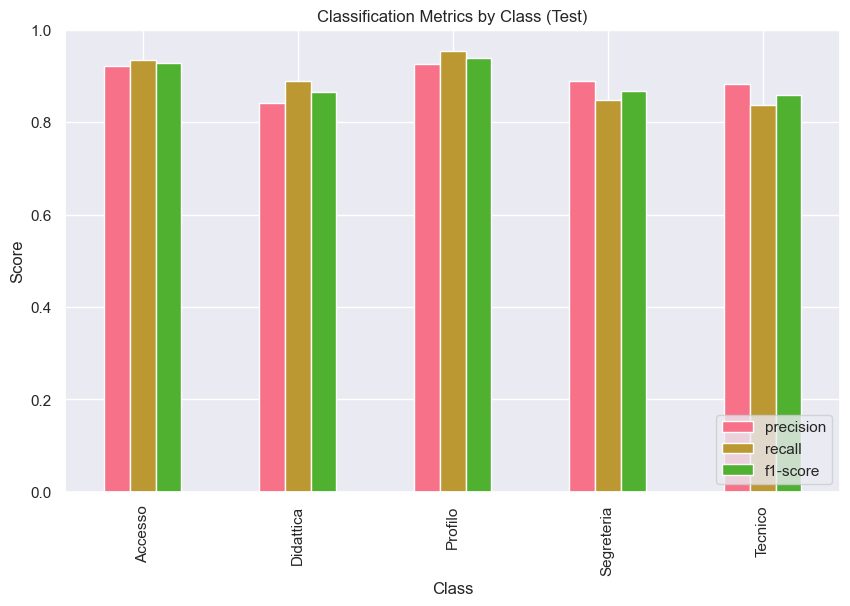

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.8904
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.919903  0.941615  0.930632   805.000000
Didattica      0.846238  0.894009  0.869468   868.000000
Profilo        0.946497  0.942893  0.944692   788.000000
Segreteria     0.899876  0.835821  0.866667   871.000000
Tecnico        0.848946  0.845974  0.847458   857.000000
accuracy       0.890427  0.890427  0.890427     0.890427
macro avg      0.892292  0.892063  0.891783  4189.000000
weighted avg   0.890961  0.890427  0.890287  4189.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[758   7  10  10  20]
 [  4 776   3  51  34]
 [ 18   8 743   6  13]
 [  2  66  13 728  62]
 [ 42  60  16  14 725]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.9094
[INFO] Classification Report (T

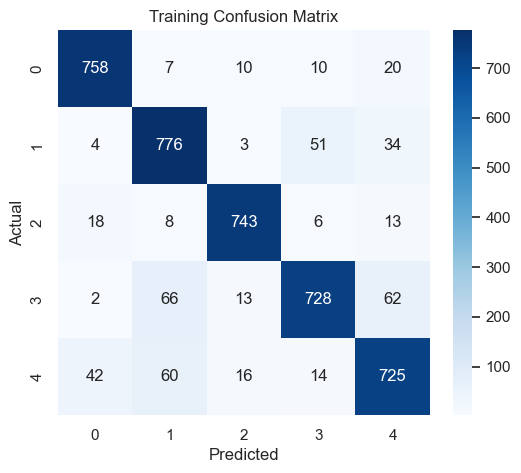

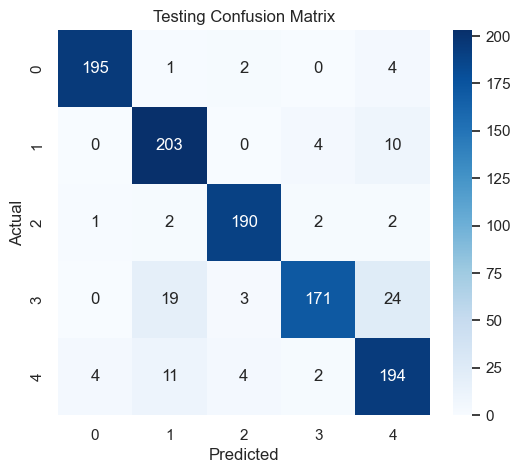

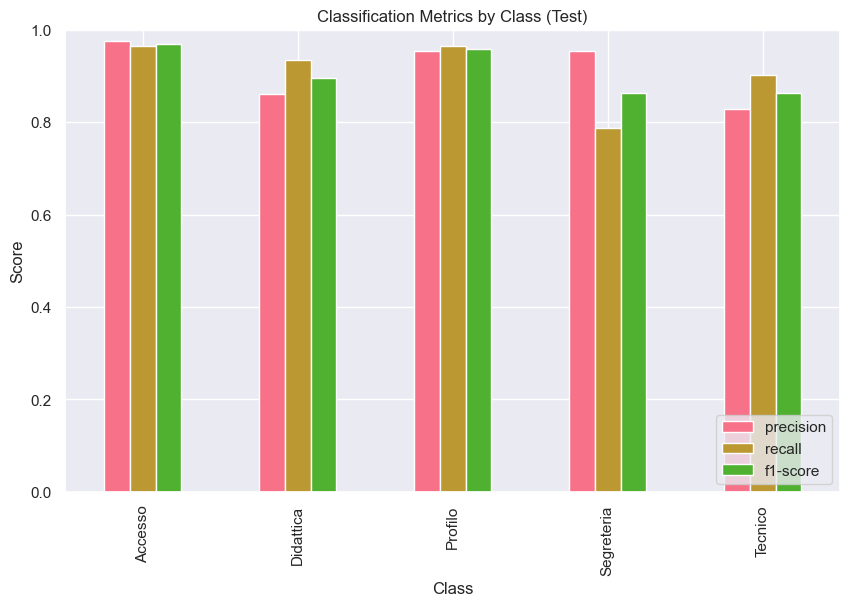

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.8959
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.930403  0.945409  0.937846   806.000000
Didattica      0.852654  0.906682  0.878839   868.000000
Profilo        0.946903  0.950508  0.948702   788.000000
Segreteria     0.908976  0.826437  0.865744   870.000000
Tecnico        0.851039  0.858974  0.854988   858.000000
accuracy       0.895943  0.895943  0.895943     0.895943
macro avg      0.897995  0.897602  0.897224  4190.000000
weighted avg   0.896699  0.895943  0.895725  4190.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[762   6  10   9  19]
 [  3 787   2  44  32]
 [ 15   8 749   6  10]
 [  2  67  14 719  68]
 [ 37  55  16  13 737]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.8873
[INFO] Classification Report (T

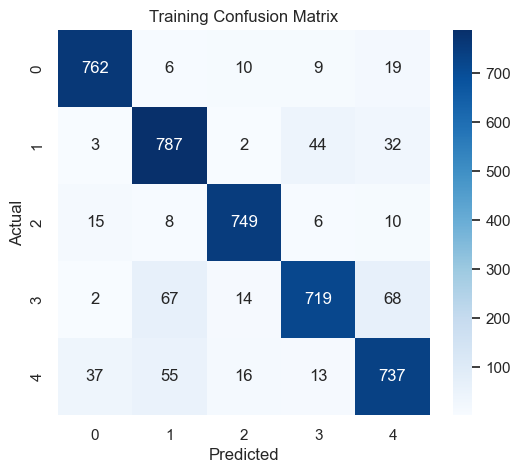

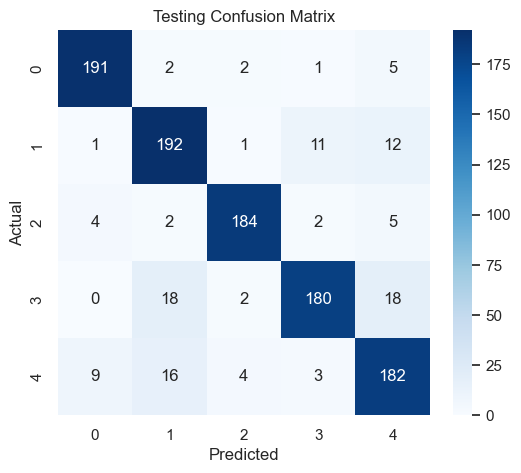

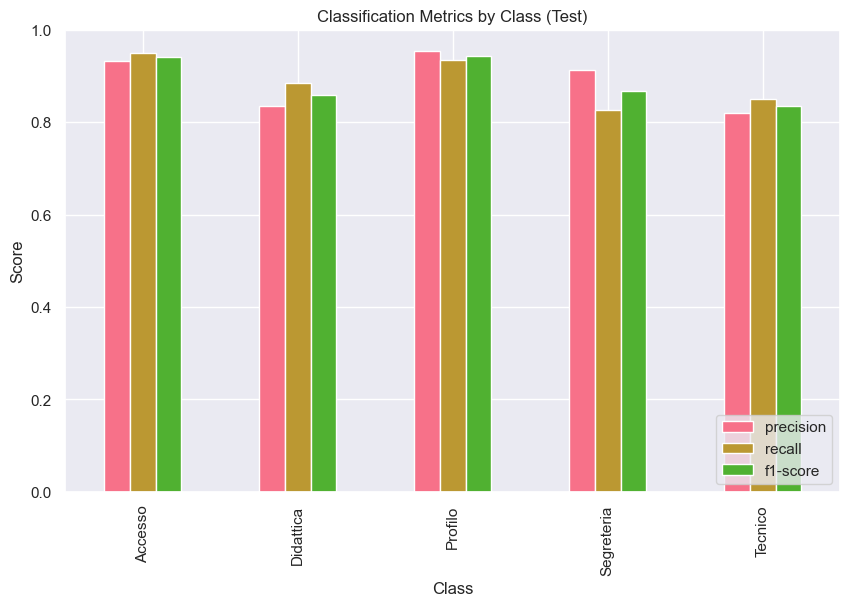

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.8952
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.936353  0.949132  0.942699   806.000000
Didattica      0.851852  0.900922  0.875700   868.000000
Profilo        0.951899  0.954315  0.953105   788.000000
Segreteria     0.907125  0.819540  0.861111   870.000000
Tecnico        0.840728  0.861305  0.850892   858.000000
accuracy       0.895227  0.895227  0.895227     0.895227
macro avg      0.897591  0.897043  0.896701  4190.000000
weighted avg   0.896121  0.895227  0.895036  4190.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[765   5   9   7  20]
 [  3 782   2  46  35]
 [ 13   7 752   7   9]
 [  1  68  12 713  76]
 [ 35  56  15  13 739]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.8902
[INFO] Classification Report (T

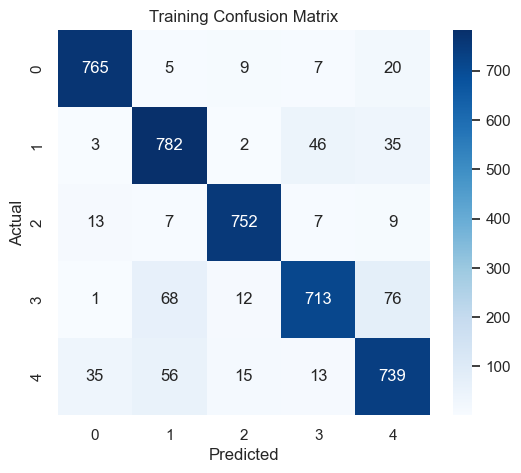

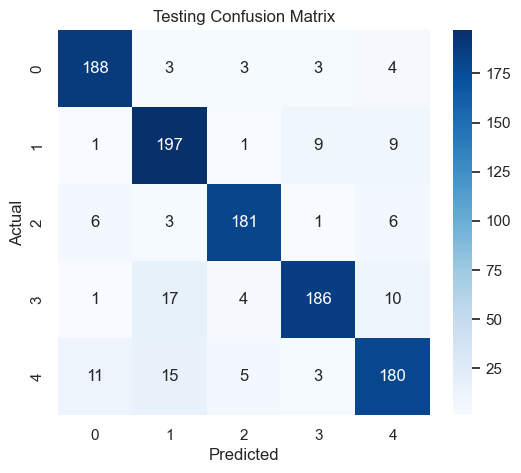

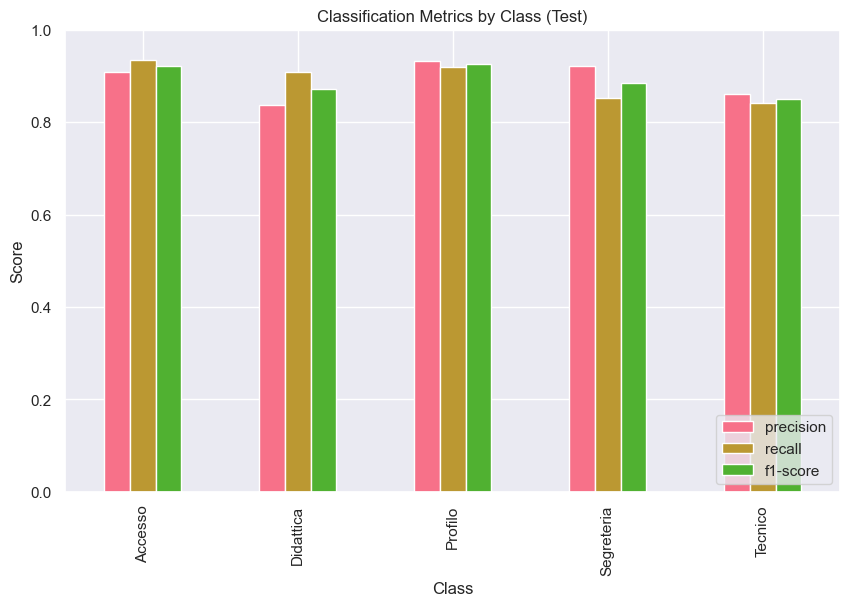

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.8945
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.933905  0.946650  0.940234   806.000000
Didattica      0.844086  0.904378  0.873192   868.000000
Profilo        0.941698  0.942893  0.942295   788.000000
Segreteria     0.918471  0.828736  0.871299   870.000000
Tecnico        0.846951  0.857809  0.852345   858.000000
accuracy       0.894511  0.894511  0.894511     0.894511
macro avg      0.897022  0.896093  0.895873  4190.000000
weighted avg   0.895753  0.894511  0.894423  4190.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[763   8  11   8  16]
 [  3 785   3  41  36]
 [ 16   9 743   6  14]
 [  2  67  13 721  67]
 [ 33  61  19   9 736]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.8930
[INFO] Classification Report (T

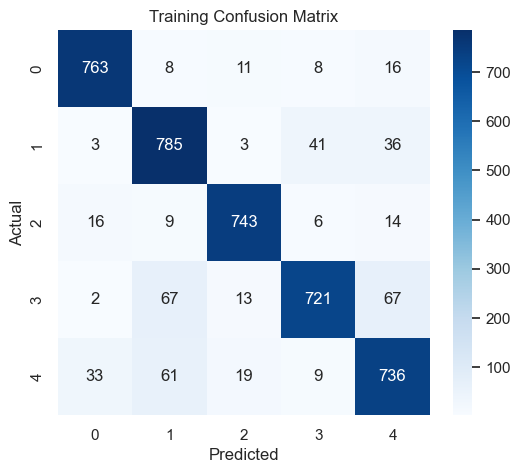

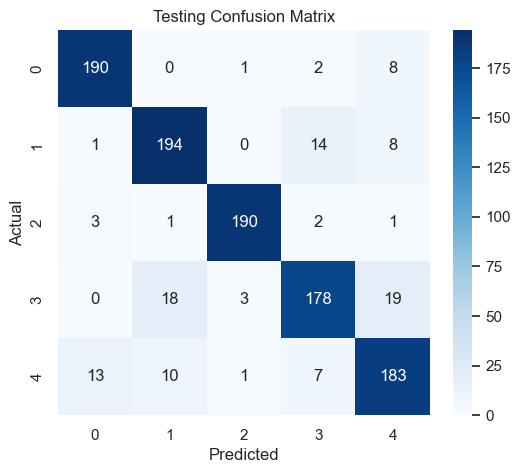

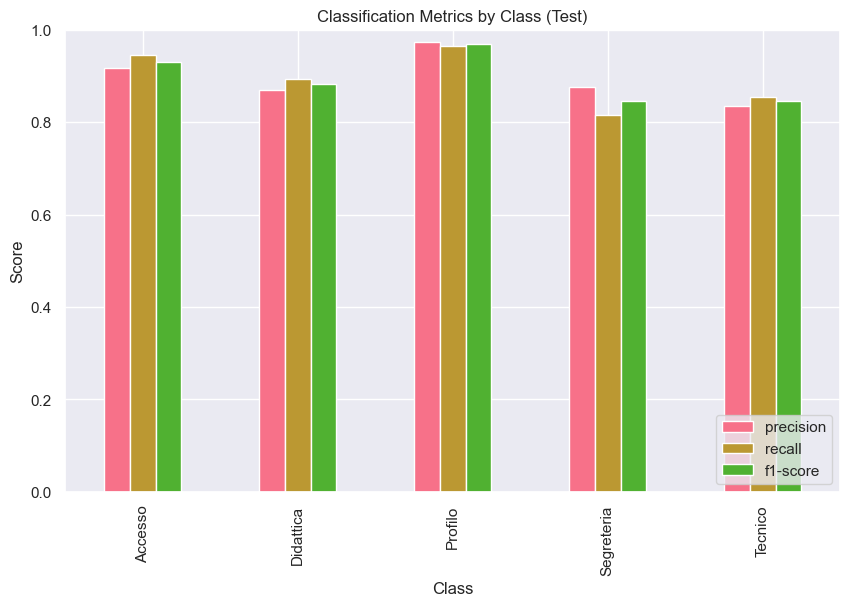

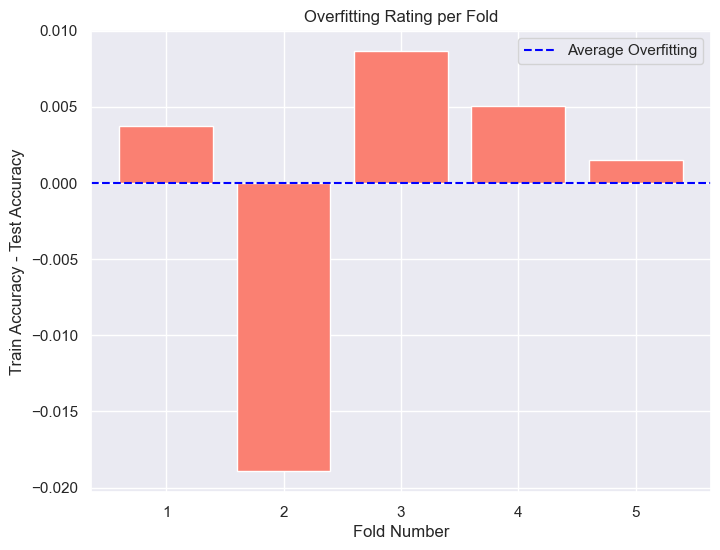

[INFO] Final average evaluation: {'train': {'avg_accuracy': np.float64(0.8942140997760358), 'avg_auc': None, 'avg_confusion_matrix': array([[762.4,   6.4,   9.6,   8. ,  19.2],
       [  3.2, 783.2,   2.4,  44. ,  35.2],
       [ 15.2,   8. , 746.4,   6.4,  12. ],
       [  1.6,  68. ,  12.8, 719.2,  68.8],
       [ 36.8,  56.8,  16. ,  12.8, 735.2]]), 'avg_classification_report':               precision    recall  f1-score      support
Accesso        0.930682  0.946375  0.938460   805.600000
Didattica      0.849096  0.902304  0.874886   868.000000
Profilo        0.948180  0.947208  0.947689   788.000000
Segreteria     0.909988  0.826286  0.866088   870.400000
Tecnico        0.844727  0.857275  0.850924   857.600000
accuracy       0.894214  0.894214  0.894214     0.894214
macro avg      0.896535  0.895890  0.895609  4189.600000
weighted avg   0.895177  0.894214  0.894071  4189.600000}, 'test': {'avg_accuracy': np.float64(0.8942119250202323), 'avg_auc': None, 'avg_confusion_matrix': arr

Calcolando la predizione per l'input: " Problema con la stampante. La stampante non funziona correttamente. "...
Predizioni: [('Tecnico', np.float64(0.9577966493945307)), ('Accesso', np.float64(0.02154404056929575)), ('Didattica', np.float64(0.012035672540030582))]


In [162]:
example_title = "Problema con la stampante."
example_message = "La stampante non funziona correttamente."
svm_predictions = ticket_service(example_title, example_message, ClassifierType.SVM)

In [163]:
pd.DataFrame(svm_predictions, columns=["Class", "Probability"])

,Class,Probability
0,Tecnico,0.957797
1,Accesso,0.021544
2,Didattica,0.012036


## Esempio di utilizzo con NAIVE BAYES

[INFO] Retrieving final model (Otherwise loading if already exists)...
[INFO] No saved model found for naive_bayes. Training a new one...
[INFO] Building pipeline for naive_bayes...
[INFO] Starting grid search for naive_bayes with parameters: {'tfidf__min_df': [1, 3], 'tfidf__max_df': [0.85, 0.9], 'clf__alpha': [1.0, 1.5, 2.0]}


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[INFO] Grid search for naive_bayes complete.
[INFO] Best parameters: {'clf__alpha': 1.0, 'tfidf__max_df': 0.85, 'tfidf__min_df': 3}
[INFO] Model saved to C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_nb.pkl.
[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.9184
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.936905  0.977640  0.956839   805.000000
Didattica      0.921729  0.908986  0.915313   868.000000
Profilo        0.931846  0.954315  0.942947   788.000000
Segreteria     0.942748  0.850746  0.894387   871.000000
Tecnico        0.864444  0.907818  0.885600   857.000000
accuracy       0.918358  0.918358  0.918358     0.918358
macro avg      0.919535  0.919901  0.919017  4189.000000
weighted avg   0.919199  0.918358  0.918062  4189.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria'

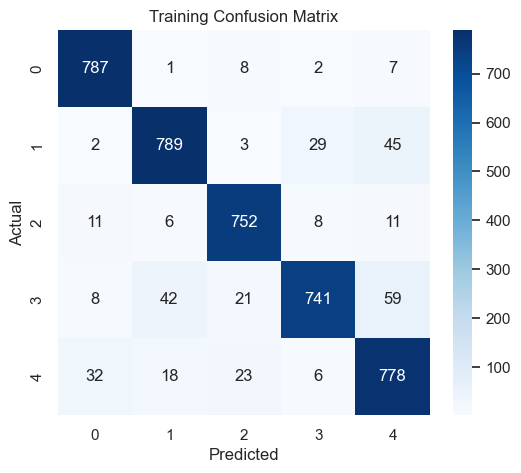

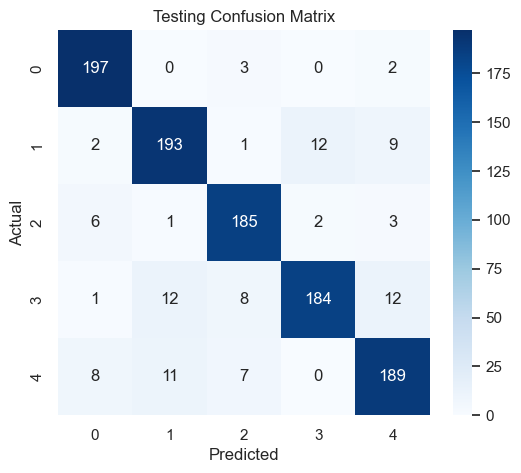

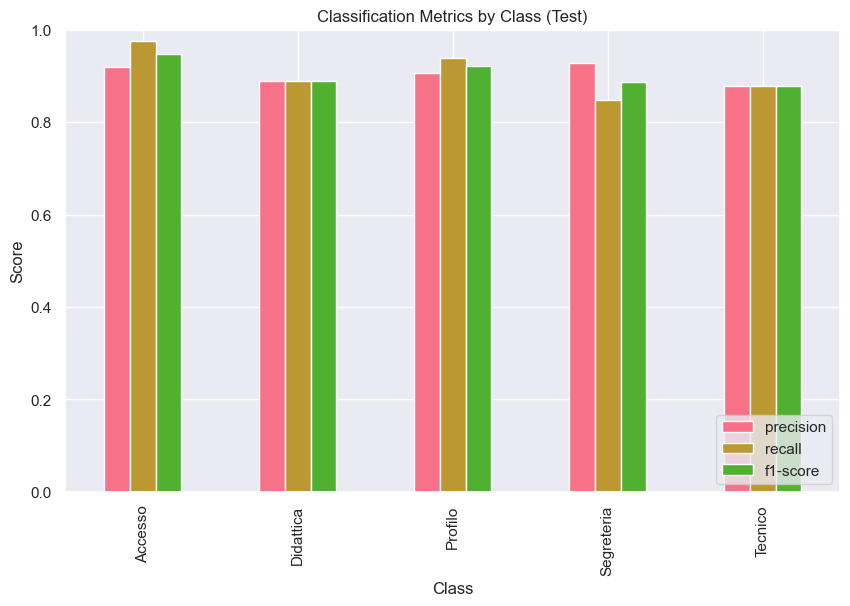

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.9133
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.925795  0.976398  0.950423   805.000000
Didattica      0.910776  0.905530  0.908146   868.000000
Profilo        0.924318  0.945431  0.934755   788.000000
Segreteria     0.934591  0.853042  0.891957   871.000000
Tecnico        0.874429  0.893816  0.884016   857.000000
accuracy       0.913344  0.913344  0.913344     0.913344
macro avg      0.913982  0.914843  0.913859  4189.000000
weighted avg   0.913725  0.913344  0.912973  4189.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[786   1  10   1   7]
 [  3 786   4  37  38]
 [ 17   5 745   8  13]
 [  7  47  22 743  52]
 [ 36  24  25   6 766]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.9246
[INFO] Classification Report (T

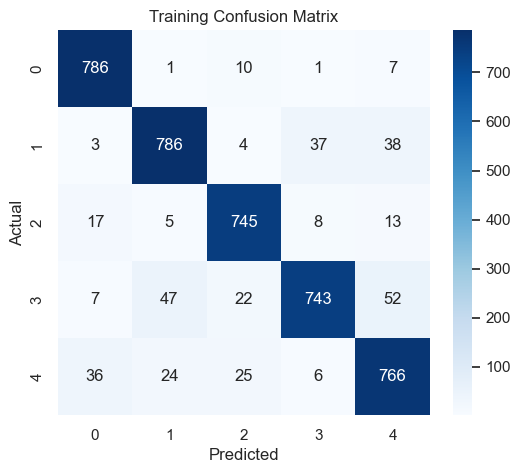

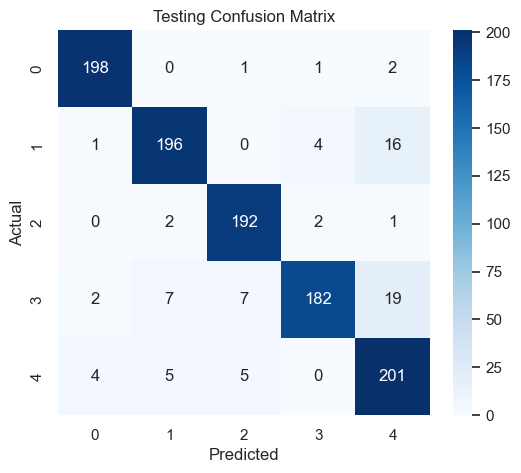

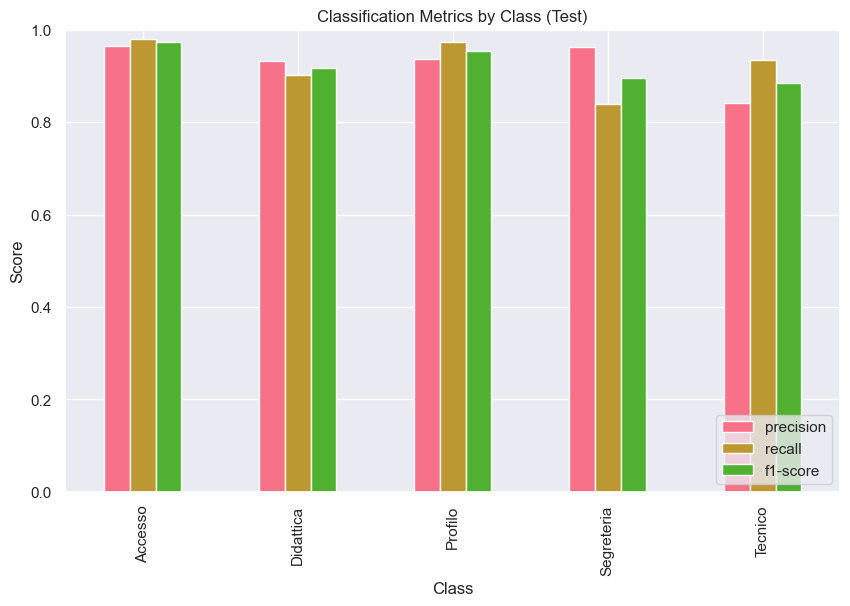

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.9167
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.938095  0.977667  0.957473   806.000000
Didattica      0.913395  0.911290  0.912341   868.000000
Profilo        0.928218  0.951777  0.939850   788.000000
Segreteria     0.938776  0.845977  0.889964   870.000000
Tecnico        0.869955  0.904429  0.886857   858.000000
accuracy       0.916706  0.916706  0.916706     0.916706
macro avg      0.917688  0.918228  0.917297  4190.000000
weighted avg   0.917309  0.916706  0.916331  4190.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[788   0   8   2   8]
 [  3 791   2  33  39]
 [ 13   4 750   9  12]
 [  7  45  25 736  57]
 [ 29  26  23   4 776]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.9112
[INFO] Classification Report (T

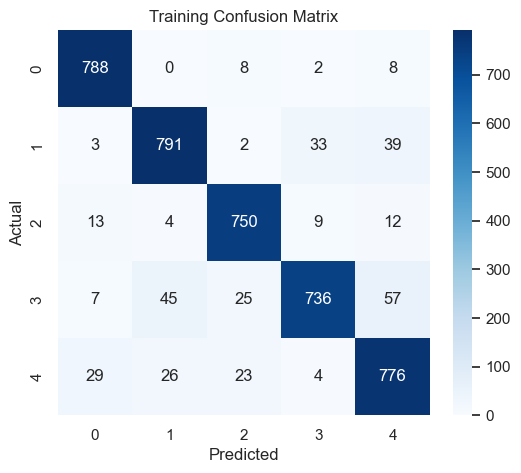

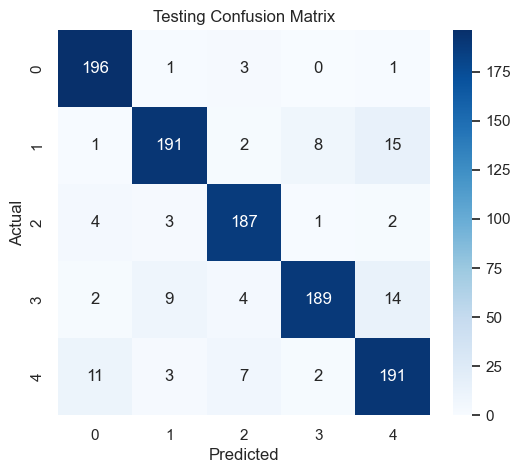

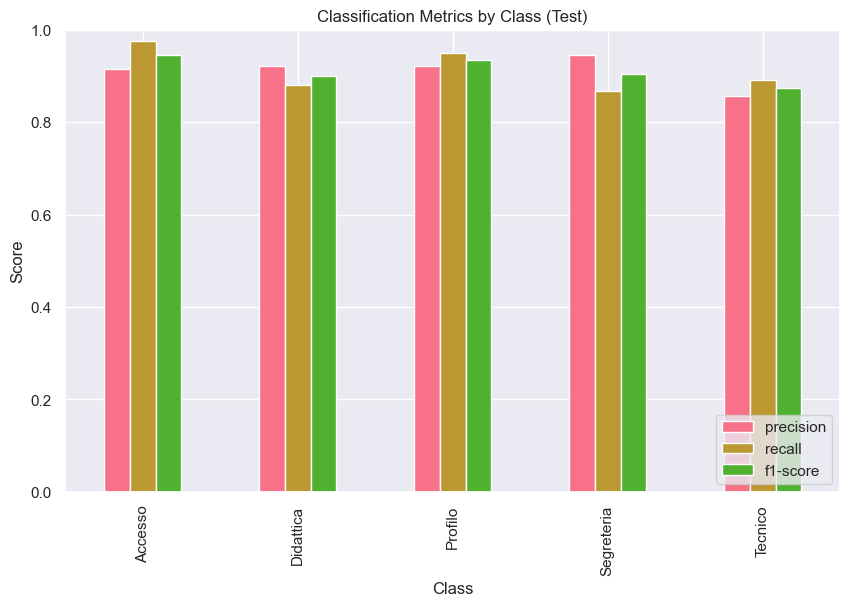

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.9153
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.938095  0.977667  0.957473   806.000000
Didattica      0.914420  0.898618  0.906450   868.000000
Profilo        0.930693  0.954315  0.942356   788.000000
Segreteria     0.938854  0.847126  0.890634   870.000000
Tecnico        0.860619  0.906760  0.883087   858.000000
accuracy       0.915274  0.915274  0.915274     0.915274
macro avg      0.916536  0.916897  0.916000  4190.000000
weighted avg   0.916091  0.915274  0.914950  4190.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[788   1   8   2   7]
 [  4 780   3  34  47]
 [ 12   7 752   8   9]
 [  6  41  23 737  63]
 [ 30  24  22   4 778]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.9169
[INFO] Classification Report (T

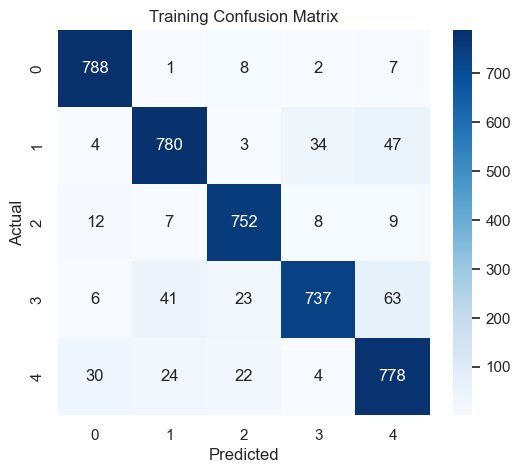

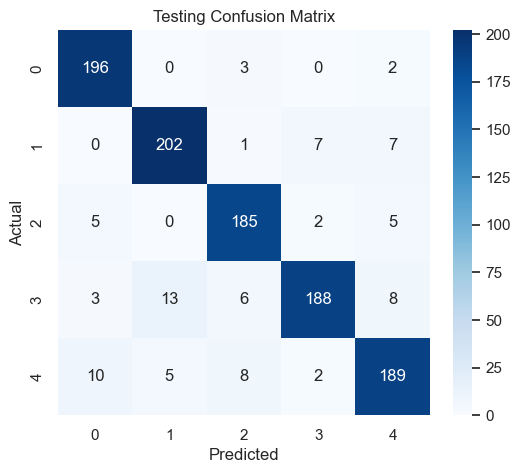

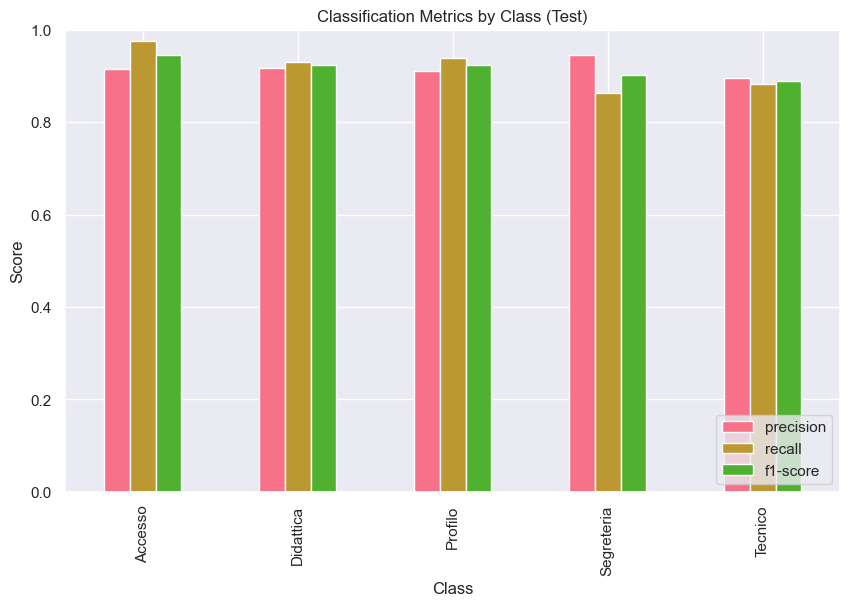

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.9143
[INFO] Classification Report (Train):
              precision    recall  f1-score     support
Accesso        0.929162  0.976427  0.952208   806.00000
Didattica      0.915691  0.900922  0.908246   868.00000
Profilo        0.919018  0.950508  0.934498   788.00000
Segreteria     0.945293  0.854023  0.897343   870.00000
Tecnico        0.867117  0.897436  0.882016   858.00000
accuracy       0.914320  0.914320  0.914320     0.91432
macro avg      0.915256  0.915863  0.914862  4190.00000
weighted avg   0.915108  0.914320  0.914005  4190.00000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[787   1  10   1   7]
 [  4 782   4  31  47]
 [ 15   6 749   7  11]
 [  8  41  25 743  53]
 [ 33  24  27   4 770]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.9207
[INFO] Classification Report (Test):
   

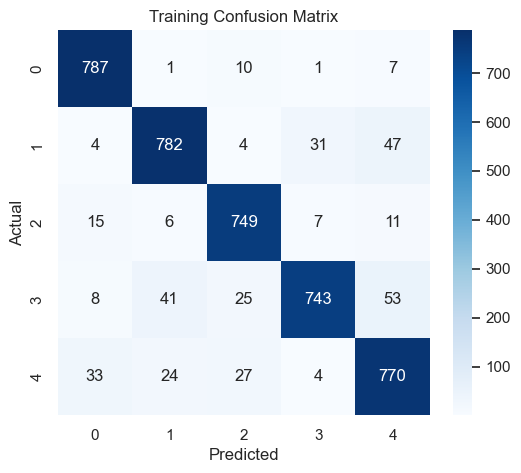

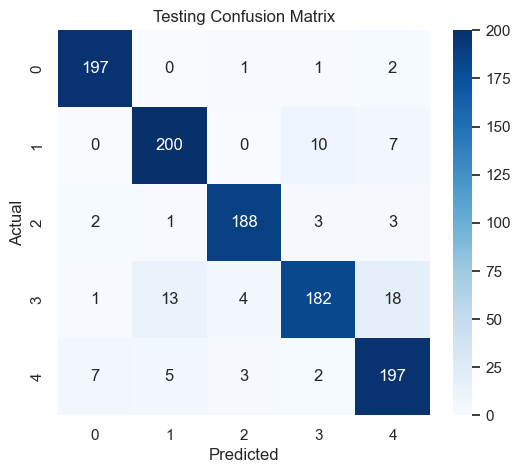

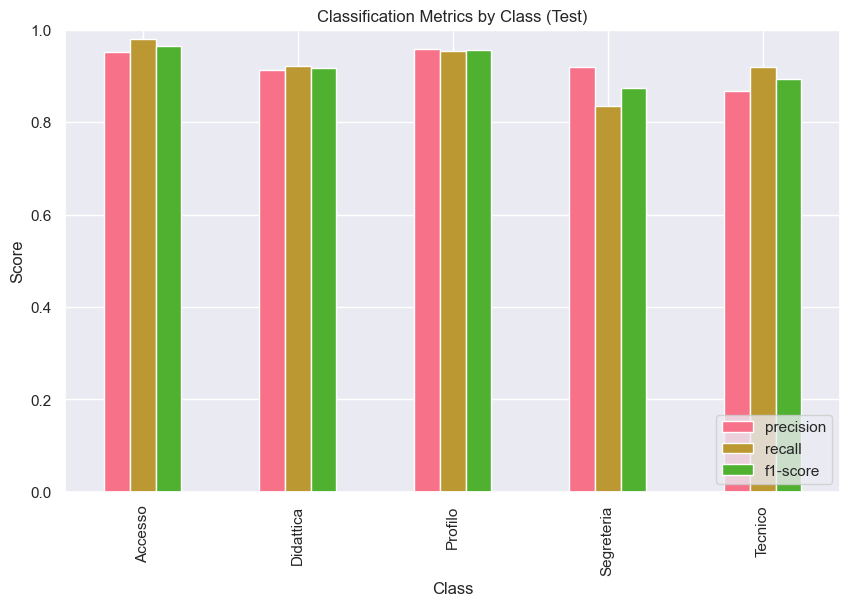

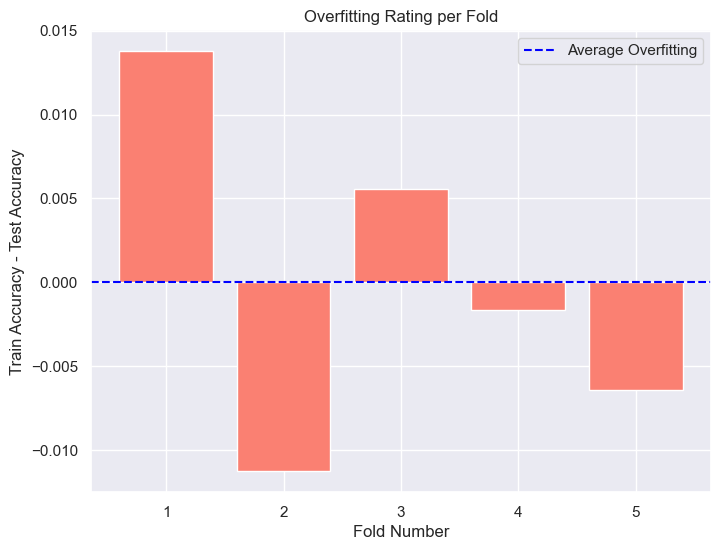

[INFO] Final average evaluation: {'train': {'avg_accuracy': np.float64(0.9156005585716882), 'avg_auc': None, 'avg_confusion_matrix': array([[787.2,   0.8,   8.8,   1.6,   7.2],
       [  3.2, 785.6,   3.2,  32.8,  43.2],
       [ 13.6,   5.6, 749.6,   8. ,  11.2],
       [  7.2,  43.2,  23.2, 740. ,  56.8],
       [ 32. ,  23.2,  24. ,   4.8, 773.6]]), 'avg_classification_report':               precision    recall  f1-score      support
Accesso        0.933610  0.977160  0.954883   805.600000
Didattica      0.915202  0.905069  0.910099   868.000000
Profilo        0.926819  0.951269  0.938881   788.000000
Segreteria     0.940052  0.850183  0.892857   870.400000
Tecnico        0.867313  0.902052  0.884315   857.600000
accuracy       0.915601  0.915601  0.915601     0.915601
macro avg      0.916599  0.917147  0.916207  4189.600000
weighted avg   0.916286  0.915601  0.915264  4189.600000}, 'test': {'avg_accuracy': np.float64(0.9156009171970807), 'avg_auc': None, 'avg_confusion_matrix': arr

Calcolando la predizione per l'input: " Problema con la stampante. La stampante non funziona correttamente. "...
Predizioni: [(np.str_('Tecnico'), np.float64(0.81472951278006)), (np.str_('Accesso'), np.float64(0.07504706965467249)), (np.str_('Didattica'), np.float64(0.039580778563803015))]


In [164]:
example_title = "Problema con la stampante."
example_message = "La stampante non funziona correttamente."
naive_bayes_predictions = ticket_service(example_title, example_message, ClassifierType.NAIVE_BAYES)

In [165]:
pd.DataFrame(naive_bayes_predictions, columns=["Class", "Probability"])

,Class,Probability
0,Tecnico,0.814730
1,Accesso,0.075047
2,Didattica,0.039581
